# 2022/01/08/SAT

> ### ***`LightGBM`***
 :   XGBoost보다 학습에 걸리는 시간이 적다. 10,000건 이하의 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다. 리프 중심 트리(Leaf Wise) 분할 방식을 사용한다. 기존의 대부분 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할(Level wise) 방식을 사용. 즉 최대한 규형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화될 수 있다. 하지만 LightGBM의 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다. 하지만 이렇게 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국은 균형 트리 방식보다 예측 오류 손실을 최소화할 수 있다는 것이 LightGBM의 구현 사상이다. Xgboost와 다르게 리프 노드가 계속 분할되면서 트리의 깊이가 깊어지므로 이러한 트리 특성에 맞는 하이퍼 파라미터 설정이 필요하다.  (245p 균형 트리 분할과 리프 중심 트리 분할 도식화한 거 살펴보기)

learning_rate를 작게 하면서 n_estimators를 크게 하는 것이 부스팅 계열 튜닝에서 가장 기본적이 튜닝 방안이다.

LightGBM을 이용해 위스콘신 유방암 데이터 세트를 예측해보자.

In [1]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target


# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(ftr, target, test_size=0.2, random_state=156 )

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정. 
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                 eval_set=evals, verbose=True)

preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

C:\Users\ehfus\Anaconda3\envs\dv2021\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ehfus\Anaconda3\envs\dv2021\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


조기 중단으로 145번 반복까지만 수행하고 학습을 종료. 이제 학습된 LightGBM 모델을 기반으로 예측 성능을 평가해보자

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [3]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870,    F1: 0.9682, AUC:0.9905


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

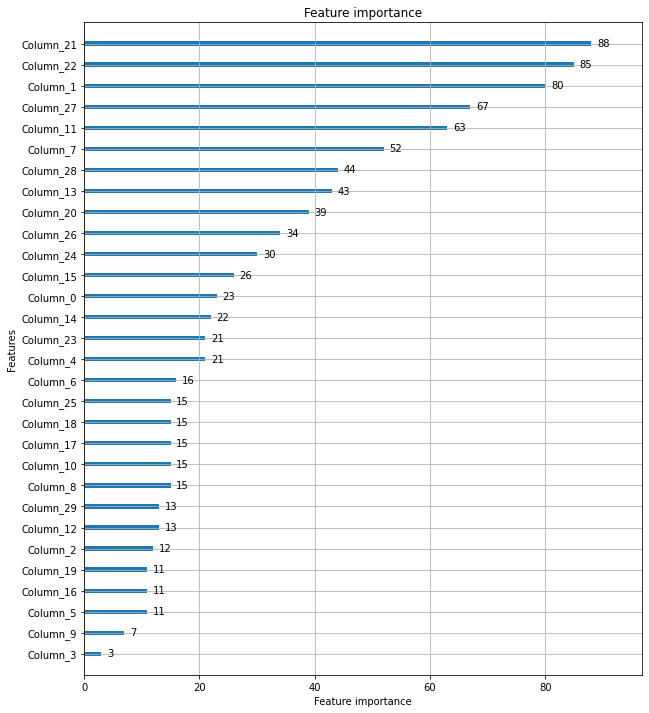

In [4]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(lgbm_wrapper, ax=ax)

이번에는 캐글의 산탄데르 고객 만족 데이터 세트에 대해 고객 만족 여부를 XGBoost와 LightGBM을 활용해 예측해보자

> 데이터 전처리 먼저!

In [5]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


- 클래스 값 포함한 feature가 371개

In [6]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


- null값 없음 $\to$ 그러나 null값이 없는 대신 극단적인 숫자로 대체해놨을수도 있음

- 전체 데이터에서 만족과 불만족의 비율을 살펴보자 $\to$ 레이블인 Target 속성 값의 분포를 알아보자 

In [8]:
print(cust_df['TARGET'].value_counts())

unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1]['TARGET'].count()
total_cnt = cust_df['TARGET'].count()

print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


- 불만족 비율은 4%에 불과

In [11]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


- var3 칼럼의 경우 min값이 -999999이다. NaN값이나 특정 예외 값을 -999999로 변환한 것으로 보임. 

In [13]:
print(cust_df.var3.value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


- -999999값이 116개나 있음을 알 수 있다. 

- var3은 숫자 형이고 다른 값에 비해 -999999은 편차가 너무 심하므로 -999999을 값이 가장 많은 2로 변환하자.

- ID feature는 단순 식별자에 불과하므로 feature를 drop하자.

- 그리고 클래스 데이터 세트와 faeture 데이터 세트를 분리해 별도의 데이터 세트로 별도로 저장하자

In [14]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(76020, 369)


- 학습과 성능 평가를 위해서 원본 데이터 세트에서 학습 데이터 세트와 테스트 데이터 세트를 분리하자

- 비대칭한 데이터 세트이므로 클래스인 Target 값 분포도가 학습 데이터와 테스트 데이터 세트에 모두 비슷하게 추출됐는지 확인하자.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()

print('\n학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print('\n학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt,'\n')


학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)

학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64 



- 학습과 테스트 데이터 세트 모두 Target의 값의 분포가 원본 데이터와 유사.

- XGBoost의 학습 모델을 생성하고 예측 결과를 ROC AUC로 평가해보자

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

C:\Users\ehfus\Anaconda3\envs\dv2021\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85831	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.88072	validation_1-auc:0.84117
[16]	validation_0-auc:0.88238	validation_1-auc:0.84101
[17]	validation_0-auc:0.88354	validation_1-auc:0.84071
[18]	validation_0-au

```python
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv 를 지정하지 않음. 
gridcv = GridSearchCV(xgb_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
```

- 이전 예제의 ROC AUC보다 파라미터 조정후 성능이 좀 개선 됐음, 앞에서 구한 최적화 파라미터를 기반으로 다른 하이퍼 파라미터를 변경 또는 추가해 다시 최적화를 진행해보자

```python
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))
```

- 이전 테스트보다 살짝 향상된 결과를 나타내고 있음. XGBoost가 GBM보다는 빠르지만 아무래도 GBM을 기반으로 하고 있기 때문에 수행시간이 상당히 요구된다. 이 때문에 하이퍼 파라미터를 다양하게 나열해 파라미터를 튜닝하는 것은 많은 시간이 소모. 앙상블 계열 알고리즘에서 하이퍼 파라미터 튜닝으로 성능 수치 개선이 급격하게 되긴 어렵다. 

- 튜닝된 모델에서 각 feature의 중요도를 feature 중요도 그래프로 나타내보자

```python
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)
```

- LightGBM으로 학습을 수행하고 ROC-AUC를 측정해보자

In [23]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

C:\Users\ehfus\Anaconda3\envs\dv2021\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\ehfus\Anaconda3\envs\dv2021\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
[2]	valid_0's auc: 0.818903	valid_0's binary_logloss: 0.160006
[3]	valid_0's auc: 0.827707	valid_0's binary_logloss: 0.156323
[4]	valid_0's auc: 0.832155	valid_0's binary_logloss: 0.153463
[5]	valid_0's auc: 0.834677	valid_0's binary_logloss: 0.151256
[6]	valid_0's auc: 0.834093	valid_0's binary_logloss: 0.149427
[7]	valid_0's auc: 0.837046	valid_0's binary_logloss: 0.147961
[8]	valid_0's auc: 0.837838	valid_0's binary_logloss: 0.146591
[9]	valid_0's auc: 0.839435	valid_0's binary_logloss: 0.145455
[10]	valid_0's auc: 0.83973	valid_0's binary_logloss: 0.144486
[11]	valid_0's auc: 0.839799	valid_0's binary_logloss: 0.143769
[12]	valid_0's auc: 0.840034	valid_0's binary_logloss: 0.143146
[13]	valid_0's auc: 0.840271	valid_0's binary_logloss: 0.142533
[14]	valid_0's auc: 0.840342	valid_0's binary_logloss: 0.142036
[15]	valid_0's auc: 0.840928	valid_0's binary_logloss: 0.14161
[16]	valid_0's auc: 0.840337	valid_0's binary_loglo

- 수행시간이 더 단축됐음을 알 수 있다. 

- GridSearchCV로 좀 더 다양한 하이퍼 파라미터에 대한 튜닝을 수행해보자

```python
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
LGBM_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}


# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv 를 지정하지 않습니다. 
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
```

- 해당 하이퍼 파라미터를 LightGBM에 적용하고 다시 학습해 ROC-AUC 측정 결과를 도출해보자

```python
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=32, sumbsample=0.8, min_child_samples=100,
                          max_depth=128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))
```

> 캐글 신용카드 사기 검출

해당 데이터 세트의 레이블인 class 속성은 매우 불균형한 분포를 가지고 있다. 단 0.1%만이 사기 transaction이며 일반적으로 사기 검출(Fraud Detection)이나 이상 검출(Anomaly Detection)과 같은 데이터 세트는 극도로 불균형한 분포를 가질 수밖에 없음. 레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생. 즉 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉽다. 지도 학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요한데 대표적으로 Oversampling과 Undersampling 방법이 있으며 Oversampling 방식이 예측성능상 더 유리한 경우가 많다.

- Undersampling : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식. 10,000 : 100 비율이라면 정상 데이터 건수를 100으로 감소시키는 것. 하지만 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용 X

- Oversampling : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법. 동일한 데이터를 단순 증식하는 것은 과적합(Overfitting) 되기 때문에 원본 데이터의 feature값들을 아주 약간만 변형하여 증식시킴. 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique)이 있다. SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.

---
- 데이터 세트를 로딩하고 신용카드 사기 검출 모델을 생성하자

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- null count 없음. 

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율이 비슷하게 분할된 것을 알 수 있다. 

In [4]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64
